In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_differential_filter():
    filter_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]]) 
    filter_y = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    return filter_x, filter_y

In [3]:
def filter_image(im, filter):
    m, n = im.shape
    im = np.insert(im, n, 0, axis=1)
    im = np.insert(im, 0, 0, axis=1)

    zeros = [0 for i in range(n+2)]
    im = np.insert(im, m, zeros, axis=0)
    im = np.insert(im, 0, zeros, axis=0)

    #im = (m+2) * (n+2)
    answer = []
    for i in range(1,m+1):
        for j in range(1,n+1):
            sliced = im[i-1:i+2, j-1:j+2]
            value = np.sum(sliced*filter)
            answer.append(value)
            
    im_filtered = np.reshape(answer, (m,n))
    
    return im_filtered

In [4]:
def get_gradient(im_dx, im_dy):
    m, n = im_dx.shape
    
    grad_mag = []
    grad_angle = []
    
    for i in range(0,m):
        for j in range(0,n):
            grad_mag.append(np.sqrt(im_dx[i][j]**2 + im_dy[i][j]**2))
            grad_angle.append(np.arctan2(im_dy[i][j] , im_dx[i][j]) % np.pi)
    
    grad_mag = np.reshape(grad_mag, (m,n))
    grad_angle = np.reshape(grad_angle, (m,n))
    
    return grad_mag, grad_angle

In [5]:
def build_histogram(grad_mag, grad_angle, cell_size):
    m, n = grad_mag.shape
    angle = np.degrees(grad_angle)
    
    index = []
    for i in range(0,m):
        for j in range(0,n):
            if angle[i][j] >=165 or angle[i][j] <15 :
                index.append(0)
            elif angle[i][j] >=15 and angle[i][j] <45 :
                index.append(1)
            elif angle[i][j] >=45 and angle[i][j] <75 :
                index.append(2)
            elif angle[i][j] >=75 and angle[i][j] <105 :
                index.append(3)
            elif angle[i][j] >=105 and angle[i][j] <135 :
                index.append(4)
            elif angle[i][j] >=135 and angle[i][j] <165 :
                index.append(5)           
    index = np.reshape(index, (m,n))
    
    ori_histo = np.zeros((m//cell_size, n//cell_size, 6))
    for i in range(0, int((m//cell_size)*cell_size)):
        for j in range(0,int((n//cell_size)*cell_size)):
            ori_histo[i//cell_size][j//cell_size][index[i,j]] += grad_mag[i][j]
    return ori_histo

In [6]:
def normalizer(vector,e=0.001):
    num = len(vector)
    normalized = []
    
    h_sum = 0
    for i in range(0, num):
        h_sum += vector[i]**2
        
    under = np.sqrt(h_sum+(e**2))
    
    normalized = vector/under
    
    return normalized

In [7]:
def get_block_descriptor(ori_histo, block_size):
    M, N = ori_histo.shape[0], ori_histo.shape[1]
    ori_histo_normalized = np.zeros((M-block_size+1,N-block_size+1,(6*block_size*block_size)))
    
    for i in range(0,M-1):
        for j in range(0,N-1):
            long_array = []
            for k in range(0,block_size):
                for l in range(0,block_size):
                    long_array = np.concatenate([long_array,ori_histo[i+k,j+l,:]], axis=0)
            ori_histo_normalized[i,j,:] = normalizer(long_array)
    
    return ori_histo_normalized

In [8]:
# visualize histogram of each block
def visualize_hog(im, hog, cell_size, block_size):
    num_bins = 6
    max_len = 7  # control sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  # num_blocks_h x num_blocks_w x num_bins
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='red', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    # plt.show()
    plt.savefig('hog.png')

In [9]:
def extract_hog(im, visualize=False, cell_size=8, block_size=2):
    im = im.astype('float') / 255.0
    
    x, y = get_differential_filter()
    
    grad_mag, grad_angle = get_gradient(filter_image(im,x),filter_image(im,y))
    
    ori_histo = build_histogram(grad_mag,grad_angle,cell_size)
    
    hog = get_block_descriptor(ori_histo, block_size)
    
    if visualize == True:
        visualize_hog(im, hog, cell_size, block_size)
        
    return hog

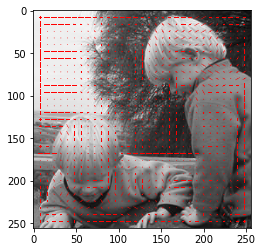

In [250]:
im = cv2.imread('twins.tif', 0)
hog = extract_hog(im, True, 8, 2)

In [231]:
def IOU(a, b):
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[0]+49, b[0]+49)
    y2 = min(a[1]+49, b[1]+49)

    inter_x = max(0, x2 - x1)
    inter_y = max(0, y2 - y1)

    inter = inter_x * inter_y
    iou = inter / (5000 - inter)
    return iou

In [175]:
def face_recognition(I_target, I_template):
    
    hog_template = extract_hog(I_template,False,8,2)
    M, N = I_target.shape
    m, n = I_template.shape
    #M, N = hog_target.shape[0], hog_target.shape[1]
    #m, n = hog_template.shape[0], hog_template.shape[1]
    
    bounding_boxes = np.zeros( ( (M-50+1)*(N-50+1),3 ) )    
    S = []
    for i in range(0,M-50+1):
        for j in range(0,N-50+1):
            hog_target = extract_hog(I_target[i:i+50,j:j+50])
            long_template = []
            long_box = []
            answer = 0
            for k in range(0,5):
                for l in range(0,5):
                    long_template = np.concatenate((long_template,hog_template[k,l,:].tolist()), axis=0)
                    long_box = np.concatenate((long_box,hog_target[k,l,:].tolist()), axis=0)
            long_template = (long_template - np.mean(long_template)) / (np.std(long_template) * len(long_template))
            long_box = (long_box - np.mean(long_box)) / (np.std(long_box))
            answer = np.correlate(long_template, long_box)
            S.append(answer[0])
            
            bounding_boxes[(N-50+1)*i+j, 0] = j
            bounding_boxes[(N-50+1)*i+j, 1] = i


    bounding_boxes[:,2] = S
    
    bounding_boxes = bounding_boxes[bounding_boxes[:,2]>=0.485]
    
    return bounding_boxes

In [93]:
def visualize_face_detection(I_target, bounding_boxes, box_size):

    hh,ww,cc=I_target.shape

    fimg=I_target.copy()
    for ii in range(bounding_boxes.shape[0]):

        x1 = bounding_boxes[ii,0]
        x2 = bounding_boxes[ii, 0] + box_size 
        y1 = bounding_boxes[ii, 1]
        y2 = bounding_boxes[ii, 1] + box_size

        if x1<0:
            x1=0
        if x1>ww-1:
            x1=ww-1
        if x2<0:
            x2=0
        if x2>ww-1:
            x2=ww-1
        if y1<0:
            y1=0
        if y1>hh-1:
            y1=hh-1
        if y2<0:
            y2=0
        if y2>hh-1:
            y2=hh-1
        fimg = cv2.rectangle(fimg, (int(x1),int(y1)), (int(x2),int(y2)), (255, 0, 0), 1)
        cv2.putText(fimg, "%.2f"%bounding_boxes[ii,2], (int(x1)+1, int(y1)+2), cv2.FONT_HERSHEY_SIMPLEX , 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    plt.figure(3)
    plt.imshow(fimg, vmin=0, vmax=1)
    plt.imsave('result_face_detection.png', fimg, vmin=0, vmax=1)
    plt.show()

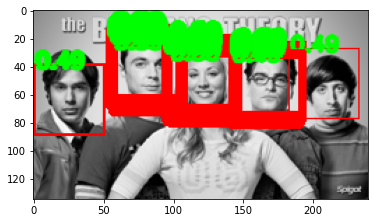

In [176]:
if __name__=='__main__':

    im = cv2.imread('cameraman.tif', 0)
    hog = extract_hog(im, visualize=False)

    I_target= cv2.imread('target.png', 0) # MxN image

    I_template = cv2.imread('template.png', 0) # mxn  face template

    bounding_boxes = face_recognition(I_target, I_template)

    I_target_c= cv2.imread('target.png') # MxN image (just for visualization)
    
    visualize_face_detection(I_target_c, bounding_boxes, I_template.shape[0]) # visualization code

In [177]:
bounding_boxes

array([[ 55.        ,  10.        ,   0.50430043],
       [ 56.        ,  10.        ,   0.51271615],
       [ 57.        ,  10.        ,   0.51183174],
       [ 58.        ,  10.        ,   0.49470459],
       [ 54.        ,  11.        ,   0.50305596],
       [ 55.        ,  11.        ,   0.54282235],
       [ 56.        ,  11.        ,   0.55987329],
       [ 57.        ,  11.        ,   0.56234894],
       [ 58.        ,  11.        ,   0.54558683],
       [ 59.        ,  11.        ,   0.49381853],
       [ 53.        ,  12.        ,   0.51972343],
       [ 54.        ,  12.        ,   0.5527324 ],
       [ 55.        ,  12.        ,   0.59514609],
       [ 56.        ,  12.        ,   0.60929087],
       [ 57.        ,  12.        ,   0.60371369],
       [ 58.        ,  12.        ,   0.57657875],
       [ 59.        ,  12.        ,   0.51924956],
       [ 52.        ,  13.        ,   0.50251092],
       [ 53.        ,  13.        ,   0.56628501],
       [ 54.        ,  13.     

In [241]:
sorted_list = sorted(bounding_boxes,key=lambda x: x[2],reverse= True)
l = len(sorted_list)
index = list(range(l))

for i in range(0,l):
    for j in range(i+1,l):
        if IOU(sorted_list[i][0:2],sorted_list[j][0:2]) >=0.5 and (j in index) :
            index.remove(j)

new_bounding_boxes = []
for i in index :
    new_bounding_boxes.append(sorted_list[i])
new_bounding_boxes = np.array(new_bounding_boxes)

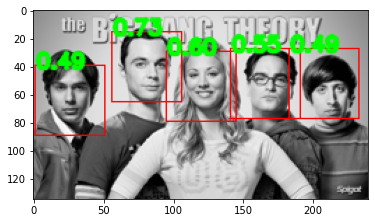

In [246]:
visualize_face_detection(I_target_c, new_bounding_boxes, I_template.shape[0]) # visualization code

In [244]:
new_bounding_boxes

array([[ 56.        ,  15.        ,   0.72863309],
       [ 95.        ,  29.        ,   0.59527696],
       [141.        ,  27.        ,   0.54516697],
       [  1.        ,  39.        ,   0.49093949],
       [183.        ,  27.        ,   0.48692324]])

In [ ]:
jupyter nbconvert --to script HOG_ver1.ipynb
